<a href="https://colab.research.google.com/github/guipantiga/rfmInitialAnalysis/blob/main/RFMAnalisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Relationship Management (CRM) - RFM Analysis using Spark

A commom method used in CRM Analytics is RFM Analysis. RFM reffers to Recency, Frequency and Monetary, a simple but very powerfull combination of customer's information.

Recency is related to the last interaction of a customer with your company. The more recently a customer has shopped, the more likely they are to keep the company in mind for future purchases. It can also be used to identify customers who have not shopped for a long time and encourage them to visit the store again.

Frequency indicates the number of times a customer makes a purchase. If it can be recognized that the customer's purchases are in a cycle, actions can be taken to predict when the customer will come back to the store or to remind them of their needs.

The monetary value is the money left by the customer as a result of these purchases, indicating the total expenditure. While the monetary value can identify the customers who spend the most, it also carries the risk of alienating customers who spend relatively small amounts or new customers.

### About

*   Data source: https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo
*   References: https://www.kaggle.com/code/sanlian/crm-rfm-analysis-with-online-retail-dataset/notebook



In [1]:
%%capture
!pip install pyspark
!pip install squarify

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

In [3]:
# Import]
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local").appName("Colab").getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Check Spark Session Information
spark

In [4]:
rawDF = spark.read.csv('/content/data.csv', encoding="ISO-8859-1", header=True)

# Preparing our Data

In [5]:
rawDF.summary().show(10, False)

+-------+------------------+------------------+------------------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|InvoiceNo         |StockCode         |Description                   |Quantity          |InvoiceDate    |UnitPrice        |CustomerID        |Country    |
+-------+------------------+------------------+------------------------------+------------------+---------------+-----------------+------------------+-----------+
|count  |541909            |541909            |540455                        |541909            |541909         |541909           |406829            |541909     |
|mean   |559965.752026781  |27623.240210938104|20713.0                       |9.55224954743324  |null           |4.611113626083471|15287.690570239585|null       |
|stddev |13428.417280805148|16799.73762842771 |null                          |218.08115785023355|null           |96.75985306117803|1713.6003033216148|null       |
|min    |536365       

In [6]:
# 1. Note that are InvoiceNo with a "C", indicading a different type of transaction
# On simple analysis, I will asume this indicates returned or wrong transactions

# 2. That are also CustomerID with null values, these are going to be removed

# 3. Any transactions with a negative value on Quantity or UnitPrice are going to be removed

# 4. Any null InvoiceDate or Description are going to be removed

# 5. any StockCode that is not a number i'm going to leave out of the analysis

In [7]:
(rawDF
      .filter(
          (F.col("CustomerID").isNotNull())
          & (F.col('Quantity') > 0)
          & (F.col('UnitPrice') > 0)
          & (F.col('InvoiceDate').isNotNull())
          & (F.col('Description').isNotNull())
          & (F.col('Description') != " ")
          & (F.trim(F.regexp_replace(F.col('StockCode'), '[^a-zA-Z]+', '')) == "")
          )
      .withColumn('Description', F.upper(F.trim(F.regexp_replace('Description', '[^a-zA-Z0-9]+', ' '))))
      .withColumn('transactionDate',
                  F.date_format(
                      F.to_date(
                          F.lpad(F.col('InvoiceDate').substr(1,10),10,'0'), 'MM/dd/yyyy')
                      , 'yyyy-MM-dd'
                      )
                  )
      ).summary().show()

+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+---------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|transactionDate|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+---------------+
|  count|            278802|            278802|              278802|            278802|         278802|           278802|            278802|     278802|         278802|
|   mean| 560590.7107266089|26860.963863243447|                null|10.280740453798753|           null|3.576125494074277|15299.405814879377|       null|           null|
| stddev|13129.998986202665|15292.519686382288|                null|210.38884618398265|           null|4.766088073911804|1708.2913954150847|       null|   

# Creating the final DataFrame

### As you can see I did not spend that much time neither I went deep into EDA analysis. I went as simple as it gets. My suggestion is to go futher and better analyse the data

In [8]:
# Begin the previous treatment for Online Retail
# Filtering
# Cleaning and formating
# Renaming Columns
# Creating Columns
# Aggregating

df = (rawDF
      .filter(
          (F.col("CustomerID").isNotNull())
          & (F.col('Quantity') > 0)
          & (F.col('UnitPrice') > 0)
          & (F.col('InvoiceDate').isNotNull())
          & (F.col('Description').isNotNull())
          & (F.col('Description') != " ")
          & (F.trim(F.regexp_replace(F.col('StockCode'), '[^a-zA-Z]+', '')) == "")
          )
      .withColumn('Description', F.upper(F.trim(F.regexp_replace('Description', '[^a-zA-Z0-9]+', ' '))))
      .withColumn('transactionDate',
                  F.date_format(
                      F.to_date(
                          F.lpad(F.col('InvoiceDate').substr(1,10),10,'0'), 'MM/dd/yyyy')
                      , 'yyyy-MM-dd'
                      )
                  )
      .select(
          F.col('CustomerID').cast('bigint').alias('customerID'),
          F.col('Country').cast('string').alias('additionalSegmentation'),
          F.col('InvoiceNo').cast('string').alias('invoiceNo'),
          F.col('Description').cast('string').alias('productDescription'),
          F.col('transactionDate'),
          F.col('Quantity').cast('bigint').alias('productQuantity'),
          F.col('UnitPrice').cast('double').alias('productPrice'),
          )
      .withColumn("monetaryValue",(F.col('productPrice')*F.col('productQuantity')).cast('decimal(19,2)'))
      .groupBy('customerID','additionalSegmentation','invoiceNo','productDescription','transactionDate')
      .agg(
          F.sum('productQuantity').cast('bigint').alias('productQuantityValue'),
          F.sum('productPrice').cast('double').alias('productPriceValue'),
          F.sum('monetaryValue').cast('double').alias('monetaryValue'),
          )
      # Separate dates into Year, month and days
      .withColumn("transactionDateYear", F.date_format(F.col("transactionDate"), "Y"))
      .withColumn("transactionDateMonth", F.date_format(F.col("transactionDate"), "MM"))
      .withColumn("transactionDateDay", F.date_format(F.col("transactionDate"), "dd"))
      .filter(
          (F.col('productDescription').isNotNull())
          & (~F.col('productDescription').isin(""," "))
          )
      ).repartition(20).sortWithinPartitions(['customerID','transactionDate'])

In [9]:
df.show(10, False)

+----------+----------------------+---------+-------------------------------+---------------+--------------------+-----------------+-------------+-------------------+--------------------+------------------+
|customerID|additionalSegmentation|invoiceNo|productDescription             |transactionDate|productQuantityValue|productPriceValue|monetaryValue|transactionDateYear|transactionDateMonth|transactionDateDay|
+----------+----------------------+---------+-------------------------------+---------------+--------------------+-----------------+-------------+-------------------+--------------------+------------------+
|12347     |Iceland               |537626   |ALARM CLOCK BAKELIKE PINK      |2010-12-07     |4                   |3.75             |15.0         |2010               |12                  |07                |
|12347     |Iceland               |537626   |BLACK CANDELABRA T LIGHT HOLDER|2010-12-07     |12                  |2.1              |25.2         |2010               |12    

In [10]:
def create_rfm_dataframe(
    df: DataFrame,
    groupByColumns: list,
    frequencyColumn: str,
    dateColumn: str,
    ) -> DataFrame:

    """
    Note that it is up to the business analyst to define what will be considered in terms of frequency.

    In this case I am going to consider that every InvoiceNo is one distinct transaction,
    but you could also use the different days between each purchase, etc.

    """

    max_date = (df.select(F.max(F.col(dateColumn)))).collect()[0][0]

    dfRFM = (df
              .withColumn('days_recency',
                          F.datediff(
                              F.to_date(
                                  F.lit(max_date), 'yyyy-MM-dd'), F.col(dateColumn)))
              .withColumn('recencyValue', (F.max('days_recency').over(Window.partitionBy(groupByColumns))*-1))
              .withColumn("days_rank",F.rank().over(Window.partitionBy(groupByColumns).orderBy(dateColumn)))
              .groupBy(*groupByColumns)
              .agg(
                  F.max('recencyValue').alias('recencyValue'),
                  F.sum('monetaryValue').alias('monetaryValue'),
                  F.countDistinct(frequencyColumn).alias('frequencyValue'),
                  F.countDistinct('transactionDate').alias('distinctDatesValue'),
                  F.countDistinct('InvoiceNo').alias('distinctOrdersValue'),
                  F.countDistinct('productDescription').alias('distinctProductsValue'),
                  )
              )

    return dfRFM

In [11]:
dfRFM = create_rfm_dataframe(
    df = df,
    groupByColumns = ['customerID','additionalSegmentation'],
    frequencyColumn = 'invoiceNo',
    dateColumn = 'transactionDate',
    )

# Create Bucket in order to build the classic RFM model

In [12]:
def create_ranges(
    df: DataFrame,
    num_buckets: int,
    column_name: str
    ):

  qds = QuantileDiscretizer(numBuckets=num_buckets, inputCol=column_name, outputCol=column_name+"Quantile", relativeError=0.01, handleInvalid="error")
  bucketizer = qds.fit(df)
  df = bucketizer.setHandleInvalid("skip").transform(df)
  df = (df.withColumn(column_name+"Quantile", (F.col(column_name+"Quantile")+1).cast('int')))

  return df

In [13]:
for i in ['recencyValue','frequencyValue','monetaryValue']:
  dfRFM = create_ranges(dfRFM, 5, i)

# Create RFM Score

## Create a concatenation of R, F and M and build some basic Scoring metrics. This metrics could be the Sum, Avg or another one that the business analyst wants to create

In [14]:
dfRFM = (dfRFM
         .withColumn('RFMConcat',
                     F.concat(
                        F.col('recencyValueQuantile').cast('int').cast('string'),
                        F.col('frequencyValueQuantile').cast('int').cast('string'),
                        F.col('monetaryValueQuantile').cast('int').cast('string')
                        )
                     )
         .withColumn('RFMSumScore',
                        (
                        F.col('recencyValueQuantile')+F.col('frequencyValueQuantile')+F.col('monetaryValueQuantile')
                        ).cast('int')
                     )
         .withColumn('RFMAvgScore',
                        (
                        (F.col('recencyValueQuantile')+F.col('frequencyValueQuantile')+F.col('monetaryValueQuantile'))/3
                        ).cast('double')
                     )
         )

# Create the basic structure for RFM Segmentation.

## It is up to the business analyst to choose wich columns to use, in this example I am going to use Recency and Frequency

In [15]:
def create_basic_rfm(
    df: DataFrame,
    yColumn: str,
    xColumn: str
    ) -> DataFrame:

    dfRFMSegmentation = (dfRFM
                         .withColumn('rfmSegmentation',
                                      F.when(
                                          (F.col(yColumn).isin(4,5))
                                          & (F.col(xColumn).isin(5))
                                          , F.lit('Champions')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(2,3))
                                          & (F.col(xColumn).isin(4,5))
                                          , F.lit('Potential Loyalists')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(1))
                                          & (F.col(xColumn).isin(5))
                                          , F.lit('New Clients')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(1))
                                          & (F.col(xColumn).isin(4))
                                          , F.lit('Promissing')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(4,5))
                                          & (F.col(xColumn).isin(3,4))
                                          , F.lit('Loyal Customers')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(3))
                                          & (F.col(xColumn).isin(3))
                                          , F.lit('Need Attention')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(1,2))
                                          & (F.col(xColumn).isin(3))
                                          , F.lit('About To Sleep')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(5))
                                          & (F.col(xColumn).isin(1,2))
                                          , F.lit('Cant Loose')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(3,4))
                                          & (F.col(xColumn).isin(1,2))
                                          , F.lit('At Risk')
                                          )
                                      .when(
                                          (F.col(yColumn).isin(1,2))
                                          & (F.col(xColumn).isin(1,2))
                                          , F.lit('Hibernating')
                                          )
                          .otherwise(F.lit('Missing'))
                          )
                     )

    return dfRFMSegmentation

In [16]:
dfRFMSegmentation = create_basic_rfm(
    df = df,
    yColumn = 'frequencyValueQuantile',
    xColumn = 'recencyValueQuantile'
    )

In [17]:
(dfRFMSegmentation
 .groupBy('rfmSegmentation')
 .agg(
    F.max('RFMConcat').alias('max_RFMConcat'),
    F.min('RFMConcat').alias('min_RFMConcat'),
    F.count('customerID').alias('count_customer'),
    F.avg('recencyValue').cast('decimal(10,2)').alias('avg_recencyValue'),
    F.avg('frequencyValue').cast('decimal(10,2)').alias('avg_frequencyValue'),
    F.avg('monetaryValue').cast('decimal(10,2)').alias('avg_monetaryValue'),
    )
 .orderBy('max_RFMConcat', ascending=False)
 ).show(10, False)

+-------------------+-------------+-------------+--------------+----------------+------------------+-----------------+
|rfmSegmentation    |max_RFMConcat|min_RFMConcat|count_customer|avg_recencyValue|avg_frequencyValue|avg_monetaryValue|
+-------------------+-------------+-------------+--------------+----------------+------------------+-----------------+
|Champions          |555          |541          |120           |-57.45          |3.96              |1233.92          |
|Potential Loyalists|535          |421          |1344          |-87.29          |1.29              |501.49           |
|Loyal Customers    |455          |341          |694           |-212.64         |4.95              |1618.65          |
|Need Attention     |335          |331          |186           |-249.68         |2.00              |589.27           |
|About To Sleep     |325          |321          |264           |-247.89         |1.00              |269.46           |
|Cant Loose         |255          |151          

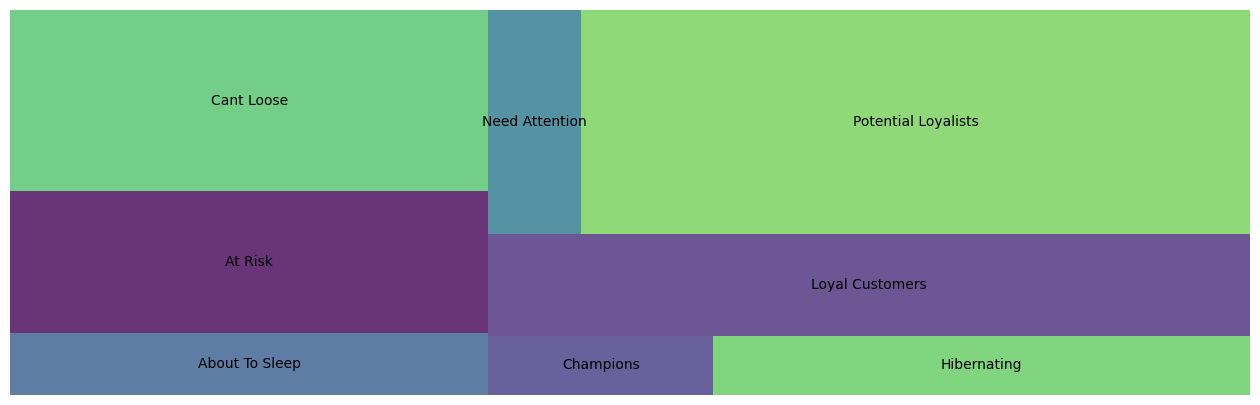

In [18]:
import matplotlib.pyplot as plt
import squarify

dfGraph = (dfRFMSegmentation.select('customerID','rfmSegmentation').groupBy('rfmSegmentation').count().orderBy('rfmSegmentation')).toPandas()

fig, ax = plt.subplots(1, figsize = (16,5))

squarify.plot(sizes=dfGraph['count'],
              label=dfGraph['rfmSegmentation'],
              alpha=.8,
             )
plt.axis('off')
plt.show()

In [19]:
dfGraph = (dfRFMSegmentation.select('customerID','monetaryValueQuantile','frequencyValueQuantile','recencyValueQuantile','monetaryValue','rfmSegmentation')).toPandas()
fig = px.density_heatmap(dfGraph, x="recencyValueQuantile", y="monetaryValueQuantile", z="monetaryValue", histfunc="avg", color_continuous_scale="Viridis")
fig.show()

# Action plan

# With this simple analysis, you can start to build strategies to act on each segment.

In [20]:
# You can verify the most bought item in each category and compare them, making the simplest recommendation.
# You can analyse this from month over month and see if a set of customers become Champion, try to mimic their behaviour or offer what they bought to another category